In [4]:
import requests
from datetime import datetime, timedelta
import pandas as pd
from tqdm import tqdm
import time
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.stats import zscore


from wordcloud import WordCloud, STOPWORDS
import json


In [5]:
# Initialise
api_key = 'API-KEY'

base_url = 'http://content.guardianapis.com/search'

## 1. Extract information about Justin Trudeau.

For this I am using Python and fetching all articles with search query `Justin Trudeau` from 2018 until today* in json. Then I am processing json to retrieve relevant records such as date, count of articles, and the section*. 

*IMPORTANT:

Please note that the current date may vary based on when I run the code to fetch data using the API.

Also, Initially, I am retrieving `Section` as well in the dataframe. 

For Task 2 and 3, as it is expected to have the datafame in certain form, I will group the data by date and have article count/date in the second column while removing the section column altogether.

### Function to fetch all the articles

In [6]:
def fetch_articles(api_key, query, from_date, to_date, page_size=200):
    base_url = "https://content.guardianapis.com/search"
    articles = []
    current_page = 1
    total_pages = 1 
    
    print(f"Fetching articles for {query} from {from_date} to {to_date}...")
    
    # Setting the params
    while current_page <= total_pages:
        params = {
            'api-key': api_key,
            'q': query,
            'from-date': from_date,
            'to-date': to_date,
            'page': current_page,
            'page-size': page_size,
            'order-by': "newest"
        }
        # Get response and save in json
        response = requests.get(base_url, params=params)
        data = response.json()
        
        if data['response']['status'] == 'ok':
            articles.extend(data['response']['results'])
            if current_page % 10 == 0 or current_page == 1 or current_page == total_pages:
                print(f"Processed page {current_page} of {data['response']['pages']}.")
            current_page += 1
            total_pages = data['response']['pages']
        else:
            print("Error fetching the data: ", data['response']['status'])
            break
    return articles

query = "Justin Trudeau"
from_date = "2018-01-01"
to_date = datetime.now().strftime('%Y-%m-%d')  # Today's date in YYYY-MM-DD format

# Calling fetch_articles function to get all the articles
articles = fetch_articles(api_key, query, from_date, to_date)


Fetching articles for Justin Trudeau from 2018-01-01 to 2024-03-27...
Processed page 1 of 51.
Processed page 10 of 51.
Processed page 20 of 51.
Processed page 30 of 51.
Processed page 40 of 51.
Processed page 50 of 51.
Processed page 51 of 51.


### Process the articles and save as a dataframe

In [7]:
articles_count = defaultdict(int)
section_names = defaultdict(set)

for article in articles:
    date = article['webPublicationDate'].split('T')[0]  # Extract just the date part
    section = article['sectionName']
    articles_count[(date, section)] += 1
    section_names[date].add(section)

data_for_df = []

for (date, section), count in articles_count.items():
    data_for_df.append({
        'Date': date,
        'Number of Articles': count,
        'SectionName': section
    })

# Create df and sort
df_w_section = pd.DataFrame(data_for_df)
df_w_section.sort_values(by=['Date', 'SectionName'], inplace=True)

# Save to CSV file
df_w_section.to_csv('articles_explore.csv', index=False)

## Explore the data frame

## 2. Number of articles about Justin Trudeau posted since 01.01.2018

In [8]:
daily_count = df_w_section.groupby('Date')['Number of Articles'].sum()
df = pd.DataFrame(daily_count).reset_index()
df.head(5)


,Date,Number of Articles
0,2018-01-01,3
1,2018-01-02,3
2,2018-01-03,5
3,2018-01-04,1
4,2018-01-05,2


In [9]:
df['Number of Articles'].sum()

10171

There have been above number of articles posted about Justin Trudeau since 01.01.2018

## 3. The average of all days from “No. of articles” for the period

In [10]:
average_articles_per_day = daily_count.mean()

print(f"Everage number of articles per day : {average_articles_per_day}")

Everage number of articles per day : 4.579468707789284


There have been more than 4 articles posted about Justin Trudeau since 01.01.2018 per day on an average.

## 4. Section for which most articles are written

In [11]:
# group by SectionName and sum the No of articles to get total articles per section
section_totals = df_w_section.groupby('SectionName')['Number of Articles'].sum()

# find the section with the most articles written
most_articles_section = section_totals.idxmax()

print(f"Section '{most_articles_section}' has most number of posts with {df_w_section['SectionName'].value_counts()[0]} articles")

Section 'World news' has most number of posts with 1070 articles


## 5.  The evolution of the "No. of articles" over time for the period 2018-Today

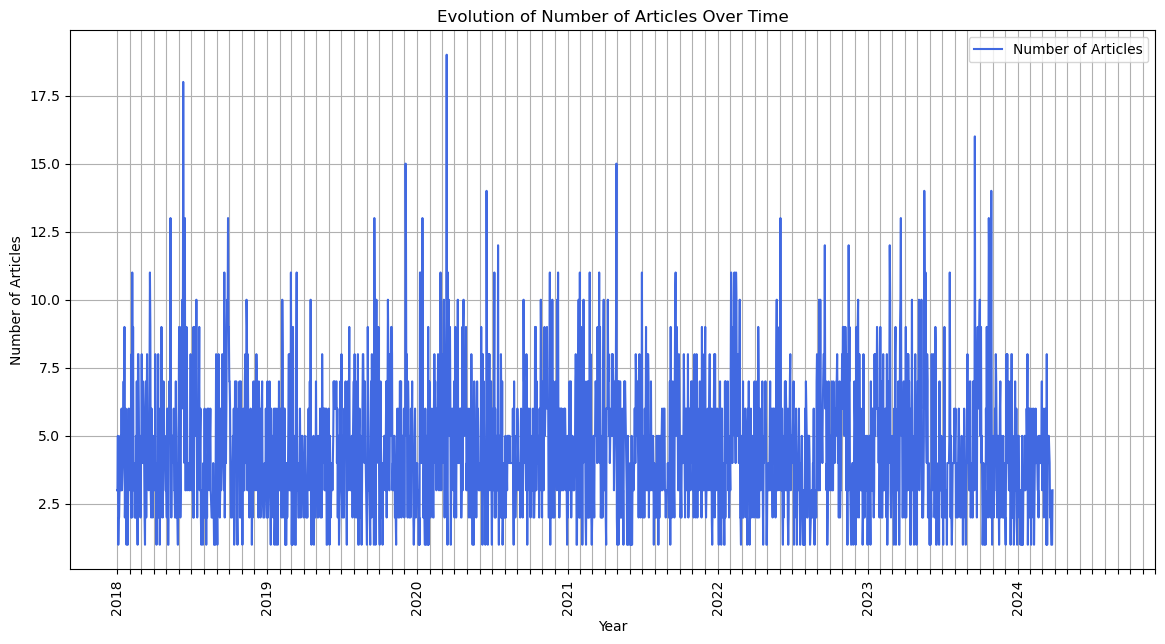

In [15]:
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Number of Articles'], label='Number of Articles', color='royalblue')

plt.title('Evolution of Number of Articles Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.legend()
plt.grid(True)

monthly_ticks = pd.date_range(start=f'{earliest_year}-01-01', end=f'{latest_year}-12-31', freq='MS')
plt.xticks(monthly_ticks, [date.strftime('%Y') for date in monthly_ticks], rotation=90)

for n, label in enumerate(plt.gca().xaxis.get_ticklabels()):
    if n % 12 != 0:
        label.set_visible(False)

# Save the plot with updated x-axis ticks
plt.show()

## 6. `Unusual` events in the time series.

Unusual Events : Yes, there seems to be some unusual events in the time series in the form of spikes in the number of articles posted.


## 7. Plot showing spikes more than usual.

There are some unusual events or ouliers as the number of articles posted were way higher than normal.

We calculate z-score values to find the outliers. The Z-score method is a statistical technique used to identify outliers within a dataset. It measures the number of standard deviations an observation is from the mean of the dataset. Based on this data we have, I have set the threshold to 5.5 to find those data points which are at the extremes.


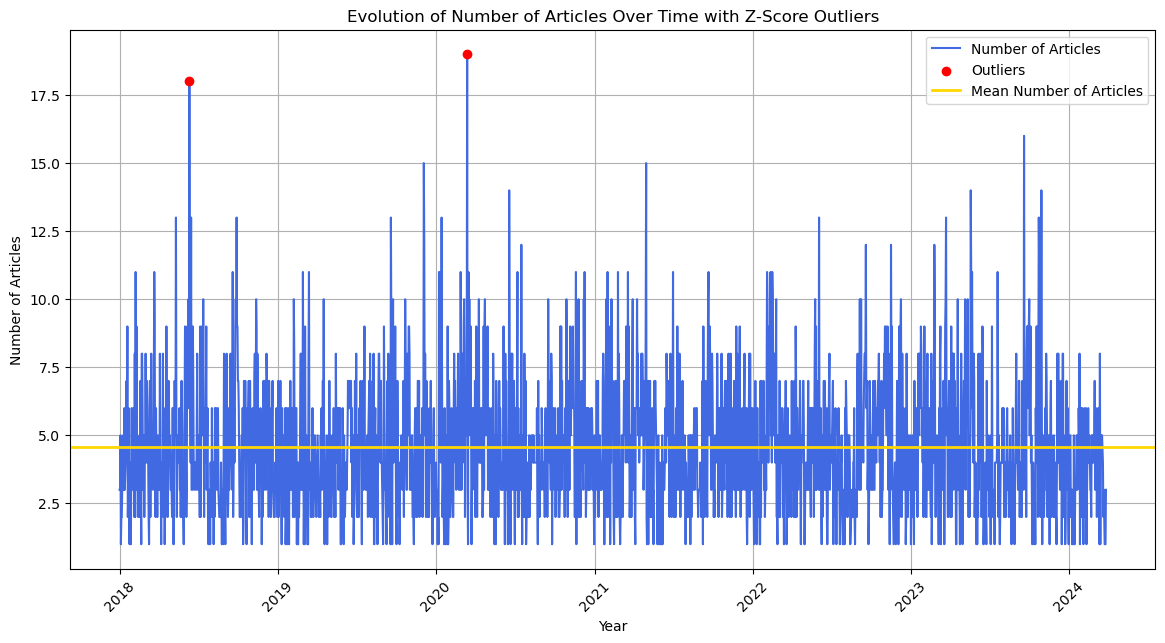

,Date,Number of Articles,Z-Score
156,2018-06-11,18,5.506410
778,2020-03-13,19,5.916707


In [16]:
# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Extract earliest and latest years from the DataFrame
earliest_year = df['Date'].dt.year.min()
latest_year = df['Date'].dt.year.max()

# Applying Z-score to detect outliers
df['Z-Score'] = zscore(df['Number of Articles'])

# Z-Score greater than 5.5 or less than -5.5 are taken as outliers
outliers = df[(df['Z-Score'] > 5.5) | (df['Z-Score'] < -5.5)]

# Plot
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Number of Articles'], label='Number of Articles', color='royalblue')
plt.scatter(outliers['Date'], outliers['Number of Articles'], color='red', label='Outliers', zorder=5)

# Plotting mean line
mean_line = df['Number of Articles'].mean()
plt.axhline(y=mean_line, color='gold', linestyle='-', label='Mean Number of Articles', linewidth = 2)

plt.title('Evolution of Number of Articles Over Time with Z-Score Outliers')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.legend()
plt.grid(True)

# Set ticks on the x-axis to show only the years from earliest to latest
plt.xticks(pd.date_range(start=f'{earliest_year}-01-01', end=f'{latest_year}-12-31', freq='YS'), 
           [year for year in range(earliest_year, latest_year + 1)], rotation=45)


plt.show()

# Returning outliers for further analysis
outliers[['Date', 'Number of Articles', 'Z-Score']]


In [17]:
df.drop(columns=['Z-Score'], inplace=True)

## 8. Cause of Unusual event 

Probable reasons for such an elevation is the number of articles for dates 2018-06-11 and 2020-03-13 are:

`2018-06-11` : "While President Trump traveled to Singapore for Tuesday's North Korea summit, his economic advisers continued his line of attack on Canadian Prime Minister Justin Trudeau" (source : https://theweek.com/10things/776688/10-things-need-know-today-june-11-2018)

`2020-03-13` : "Canada shut down Parliament and advised against all nonessential travel outside the country while Prime Minister Justin Trudeau governed remotely from his home, in self-imposed quarantine after his wife tested positive for the new coronavirus." (source : https://www.aljazeera.com/news/2020/3/13/coronavirus-canadian-parliament-shut-trudeau-quarantined)

This can also be demostrated by using a word cloud for each year. It can be observed that in 2018 news related to Trump and Trudeau were a highlight and in 2020 covid related articles were dominating the headlines in relation to Justin Trudeau. 

### WordCloud for each year with trending topics

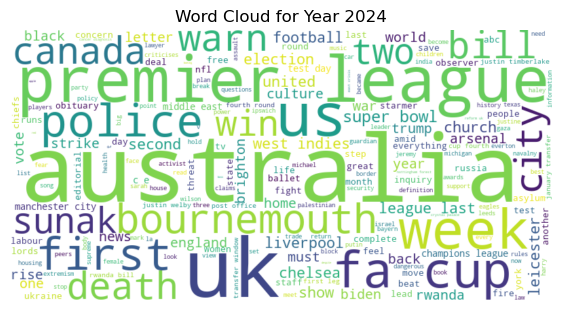

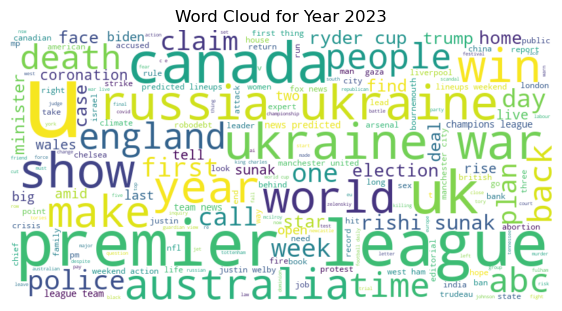

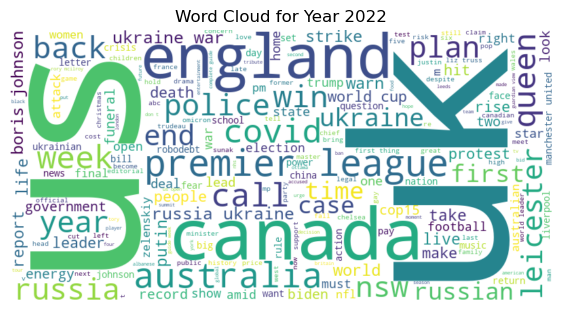

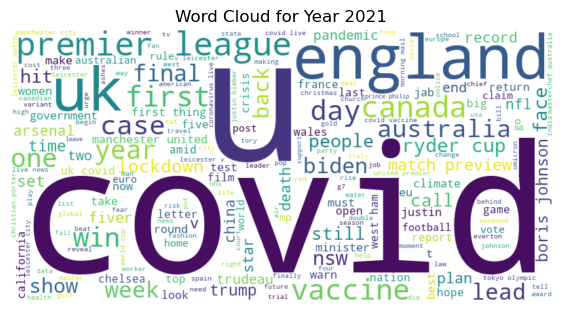

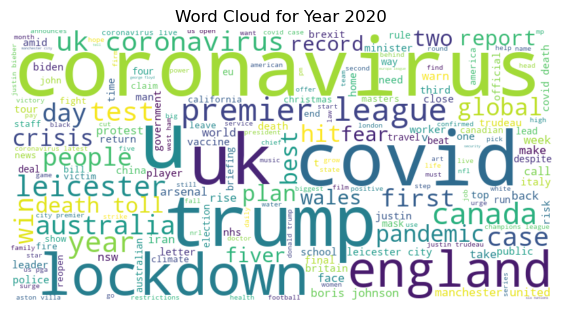

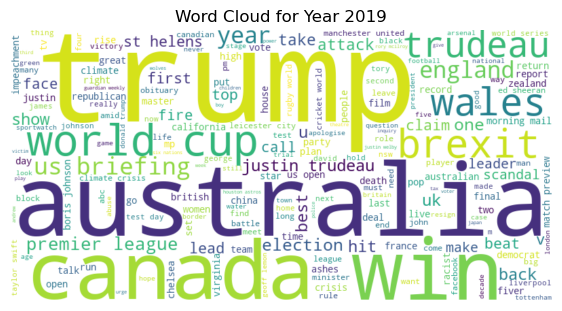

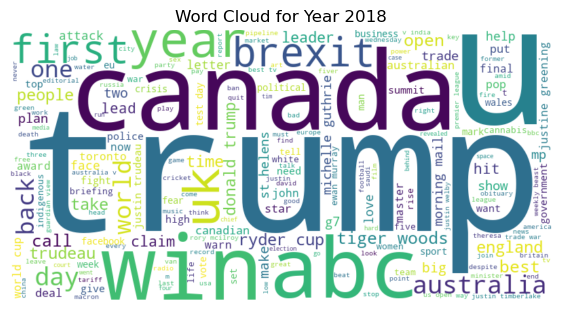

In [18]:
# Stop words based on the data
additional_stopwords = {'review','says','say','S','a', 'an', 'the', 'new', 'happened', 'is', 'of', 'and', 'in', 'to', 'for', 'on', 'with', 'as', 'it', 'by', 'this', 'that', 'from', 'be', 'are', 'was', 'were', 'have', 'has', 'had', 'will', 'shall', 'may', 'can', 'its', 'but', 'at', 'which', 'if', 'or', 'we', 'you', 'they', 'he', 'she', 'his', 'her', 'their', 'our', 'your'}

# Combining NLTK's stop words with my custom stop words
final_stopwords = set(STOPWORDS).union(additional_stopwords)

# A dictionary to hold all text by year
text_by_year = defaultdict(str)

# Process articles to accumulate text by year, excluding stop words
for article in articles:
    year = article['webPublicationDate'][:4]
    # Get the words
    # Split the title into words, exclude stop words, then rejoin
    words = [word for word in article.get('webTitle', '').lower().split() if word not in final_stopwords]
    text_by_year[year] += ' ' + ' '.join(words)

# generate and display a wordcloud for each year
for year, text in text_by_year.items():
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=final_stopwords).generate(text)
    
    # Display the wordcloud
    plt.figure(figsize=(7, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Year {year}')
    plt.axis('off')
    plt.show()


## For automation task check out the python script named : `theGuardianJob.py` 